In [2]:
#ignore
from IPython.core.display import HTML,Image
import sys
sys.path.append('/anaconda/')
import config

HTML('<style>{}</style>'.format(config.CSS))

# UNDER CONSTRUCTION!!!





## Process
1. Download covid API; download state populations; download governor stats
2. Normalize all stats by 100k
3. Encode as D/R
4. 

## Outline
* Make data for a few different feature sets, some stronger, some weaker, some useless
* Train duplicate models on similar data, with one better and one worse
* show mechanics of an ensemble trained on walk-forward predictions of base models
* Compare results of ensemble vs. base models vs. big soup using scorecard
* Illustrate the problems of in-sample and negative weights on blending model


In [116]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)[['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL'],data_source='quandl',begin_date='2012-01-01',end_date=None)
# note, we're only using real price data to get an accurate date/symbol index set.  

In [158]:
# num_obs = prices.close.count()

# def add_memory(s,n_days=50,memory_strength=0.1):
#     ''' adds autoregressive behavior to series of data'''
#     add_ewm = lambda x: (1-memory_strength)*x + memory_strength*x.ewm(n_days).mean()
#     out = s.groupby(level='symbol').apply(add_ewm)
#     return out

# def make_random_walk(s,n_days=254,reversion_strenth=0.9,bias=1.):
#     ''' creates a random walk from series of IID values.  This creates
#     a feature which tends to have streaks of high and low values but 
#     eventually reverts.  Bias term sets the long-term average value.
#     When used on a multi-index, this creates some covariance _between_ 
#     symbols, which is probably more realistic'''
#     num_syms = len(s.index.get_level_values('symbol').unique())
#     rw = (1-reversion_strenth)* s.rolling(n_days*num_syms,min_periods=1).sum() + reversion_strenth*0.+bias
#     return rw


# factor_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
# #factor_1 = add_memory(factor_1,10,0.1)
# factor_1 = make_random_walk(factor_1,100,0.9,1.0)

# factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
# #factor_2 = add_memory(factor_2,10,0.1)
# factor_2 = make_random_walk(factor_2,100,0.9,1.0)

# factor_3 = pd.Series(np.random.randn(num_obs),index=prices.index)
# #factor_3 = add_memory(factor_3,10,0.1)
# factor_3 = make_random_walk(factor_3,100,0.9,1.0)


# ## generate feature data

# # Features which represent factor 1
# f11 = 0.25*factor_1  + 0.75 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f12 = 0.20*factor_1  + 0.8 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f13 = 0.15*factor_1  + 0.85 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f14 = 0.10*factor_1  + 0.90 * pd.Series(np.random.randn(num_obs),index=prices.index)

# # Features which represent factor 2
# f21 = 0.25*factor_2  + 0.75 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f22 = 0.20*factor_2  + 0.80 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f23 = 0.15*factor_2  + 0.85 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f24 = 0.10*factor_2  + 0.90 * pd.Series(np.random.randn(num_obs),index=prices.index)

# # Features which represent factor 3
# f31 = 0.25*factor_3  + 0.75 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f32 = 0.20*factor_3  + 0.20 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f33 = 0.15*factor_3  + 0.85 * pd.Series(np.random.randn(num_obs),index=prices.index)
# f34 = 0.10*factor_3  + 0.90 * pd.Series(np.random.randn(num_obs),index=prices.index)

# # interaction effects
# f41 = f11-f21
# f42 = f21-f31
# f43 = f31-f11
# f44 = f11+f21+f31

# # Consider non-linear effects

# # Random noise
# f51 = pd.Series(np.random.randn(num_obs),index=prices.index)
# f52 = pd.Series(np.random.randn(num_obs),index=prices.index)
# f53 = pd.Series(np.random.randn(num_obs),index=prices.index)
# f54 = pd.Series(np.random.randn(num_obs),index=prices.index)


# features = pd.concat([f11,f12,f13,f14,f21,f22,f23,f24,\
#                       f31,f32,f33,f34,f41,f42,f43,f44,f51,f52,f53,f54],axis=1)
# features.columns = ['f11','f12','f13','f14','f21','f22','f23','f24',\
#                       'f31','f32','f33','f34','f41','f42','f43','f44','f51','f52','f53','f54']

# ## now, create response variable such that it is related to features:
# # each factor's relationship to outcome varies in a random walk fashion
# # This also embeds some amount of cross-asset correlation

# rnd_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
# rnd_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
# rnd_3 = pd.Series(np.random.randn(num_obs),index=prices.index)

# outcome =   factor_1 * make_random_walk(rnd_1,n_days=10,reversion_strenth=0.5,bias=0.5) + \
#             factor_2 * make_random_walk(rnd_2,n_days=10,reversion_strenth=0.3,bias=1.0) + \
#             factor_3 * make_random_walk(rnd_3,n_days=10,reversion_strenth=0.1,bias=0.0) + \
#             np.random.randn(num_obs) *10 
            
# # mean-center the outcome
# outcome = outcome - outcome.mean()


# # outcome =   factor_1 * np.linspace(0.5,1.5,num_obs) + \
# #             factor_2 * np.linspace(1.5,0.5,num_obs) + \
# #             factor_3 * pd.Series(np.sin(2*np.pi*np.linspace(0,1,num_obs)*2)+1,index=prices.index) +np.random.randn(num_obs) * 5 
# outcome.name = 'outcome'

In [542]:
num_obs = prices.close.count()

def add_memory(s,n_days=50,memory_strength=0.1):
    ''' adds autoregressive behavior to series of data'''
    add_ewm = lambda x: (1-memory_strength)*x + memory_strength*x.ewm(n_days).mean()
    out = s.groupby(level='symbol').apply(add_ewm)
    return out

def make_random_walk(s,n_days=254,reversion_strenth=0.9,bias=1.):
    ''' creates a random walk from series of IID values.  This creates
    a feature which tends to have streaks of high and low values but 
    eventually reverts.  Bias term sets the long-term average value.
    When used on a multi-index, this creates some covariance _between_ 
    symbols, which is probably more realistic'''
    num_syms = len(s.index.get_level_values('symbol').unique())
    rw = (1-reversion_strenth)* s.rolling(n_days*num_syms,min_periods=1).sum() + reversion_strenth*0.+bias
    return rw


# generate some (hidden) factors in the data to discover

factor_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
#factor_1 = add_memory(factor_1,10,0.1)
factor_1 = make_random_walk(factor_1,10,0.8,0.0)

factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
#factor_2 = add_memory(factor_2,10,0.1)
factor_2 = make_random_walk(factor_2,10,0.8,0.0)

factor_3 = pd.Series(np.random.randn(num_obs),index=prices.index)
#factor_3 = add_memory(factor_3,10,0.1)
factor_3 = make_random_walk(factor_3,10,0.8,0.0)


## generate feature data

# Features which represent factor 1
f11 = 0.3*factor_1  + pd.Series(np.random.randn(num_obs),index=prices.index)
f12 = 0.2*factor_1  + pd.Series(np.random.randn(num_obs),index=prices.index)
f13 = 0.1*factor_1  + pd.Series(np.random.randn(num_obs),index=prices.index)
f14 = 0.05*factor_1  + pd.Series(np.random.randn(num_obs),index=prices.index)

# Features which represent factor 2
f21 = 0.3*factor_2  + pd.Series(np.random.randn(num_obs),index=prices.index)
f22 = 0.2*factor_2  + pd.Series(np.random.randn(num_obs),index=prices.index)
f23 = 0.1*factor_2  + pd.Series(np.random.randn(num_obs),index=prices.index)
f24 = 0.050*factor_2  + pd.Series(np.random.randn(num_obs),index=prices.index)

# Features which represent factor 3
f31 = 0.3*factor_3  + pd.Series(np.random.randn(num_obs),index=prices.index)
f32 = 0.2*factor_3  + pd.Series(np.random.randn(num_obs),index=prices.index)
f33 = 0.1*factor_3  + pd.Series(np.random.randn(num_obs),index=prices.index)
f34 = 0.05*factor_3  + pd.Series(np.random.randn(num_obs),index=prices.index)


# Random noise
f51 = pd.Series(np.random.randn(num_obs),index=prices.index)-pd.Series(np.random.randn(num_obs),index=prices.index).mean()
f52 = pd.Series(np.random.randn(num_obs),index=prices.index)-pd.Series(np.random.randn(num_obs),index=prices.index).mean()
f53 = pd.Series(np.random.randn(num_obs),index=prices.index)-pd.Series(np.random.randn(num_obs),index=prices.index).mean()
f54 = pd.Series(np.random.randn(num_obs),index=prices.index)-pd.Series(np.random.randn(num_obs),index=prices.index).mean()

features = pd.concat([f11,f12,f13,f14,f21,f22,f23,f24,\
                      f31,f32,f33,f34,f41,f42,f43,f44,f51,f52,f53,f54],axis=1)
features.columns = ['f11','f12','f13','f14','f21','f22','f23','f24',\
                      'f31','f32','f33','f34','f41','f42','f43','f44','f51','f52','f53','f54']

## now, create response variable such that it is related to features:
# each factor's relationship to outcome varies in a random walk fashion
# This also embeds some amount of cross-asset correlation

rnd_1 = add_memory(pd.Series(np.random.randn(num_obs),index=prices.index),n_days=100,memory_strength=0.95)*4
rnd_2 = add_memory(pd.Series(np.random.randn(num_obs),index=prices.index),n_days=200,memory_strength=0.95)*2
rnd_3 = add_memory(pd.Series(np.random.randn(num_obs),index=prices.index),n_days=200,memory_strength=0.95)*1

outcome =   factor_1*rnd_1 + factor_2*rnd_2 + factor_3*rnd_3 + np.random.randn(num_obs) 

# mean-center the outcome
outcome = outcome - outcome.mean()

# outcome =   factor_1 * np.linspace(0.5,1.5,num_obs) + \
#             factor_2 * np.linspace(1.5,0.5,num_obs) + \
#             factor_3 * pd.Series(np.sin(2*np.pi*np.linspace(0,1,num_obs)*2)+1,index=prices.index) +np.random.randn(num_obs) * 5 
outcome.name = 'outcome'

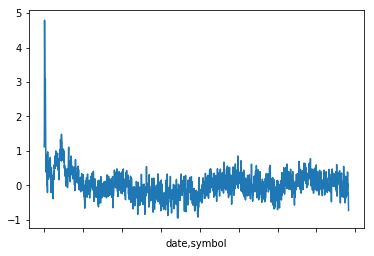

In [543]:
rnd_1.plot()

In [544]:
factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_2.tail()

date        symbol
2018-03-21  AAPL     -0.587775
2018-03-22  AAPL     -0.755820
2018-03-23  AAPL     -2.074400
2018-03-26  AAPL      0.059873
2018-03-27  AAPL      1.062163
dtype: float64

date        symbol
2018-03-21  AAPL     -2.023399
2018-03-22  AAPL     -1.931180
2018-03-23  AAPL     -2.197483
2018-03-26  AAPL     -2.139628
2018-03-27  AAPL     -2.202500
dtype: float64

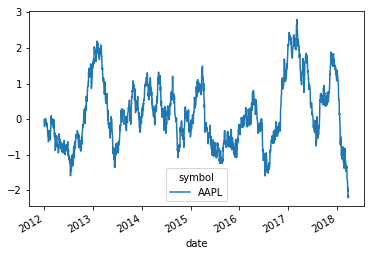

In [545]:
factor_2 = make_random_walk(factor_2,100,0.9,0.0)
factor_2.unstack().plot()
factor_2.tail()

In [546]:


model_1 = LinearRegression()
model_1.fit(X=features[['f11','f12','f13','f14']],y=outcome)

model_2 = LinearRegression()
model_2.fit(X=features[['f21','f22','f23','f24']],y=outcome)

model_3 = LinearRegression()
model_3.fit(X=features[['f31','f32','f33','f34']],y=outcome)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [547]:
print(model_1.score(X=features[['f11','f12','f13','f14']],y=outcome))
print(model_1.coef_)

0.0058463740035195055
[ 0.01146385 -0.01275775  0.05939665  0.0452884 ]


In [548]:
print(model_2.score(X=features[['f21','f22','f23','f24']],y=outcome))
print(model_2.coef_)

0.0024323312117545686
[ 0.04647748  0.01094642 -0.00599834  0.01000452]


In [549]:
print(model_3.score(X=features[['f31','f32','f33','f34']],y=outcome))
print(model_3.coef_)

0.00022285599538296452
[ 0.00849998  0.00037002 -0.0124672  -0.00129443]


## Making Base Models
Following the methodology presented in [Walk-forward modeling](walk_forward_model_building.html), we'll create five base models to use in our ensemble:
1. A simple model focused on `factor_1` features
2. A simple model focused on `factor_2` features
3. A simple model focused on `factor_3` features
4. An overly-complex model focused on `factor_1` features
5. A model of mostly non-useful features 

To make this easier to follow, I'll define a simple function called `make_walkforward_model` that trains a series of models at various points in time and generates out of sample predictions using those trained models.

In [550]:
from sklearn.base import clone

def make_walkforward_model(features,outcome,algo=LinearRegression()):
    recalc_dates = features.resample('Q',level='date').mean().index.values[:-1]
    
    ## Train models
    models = pd.Series(index=recalc_dates)
    for date in recalc_dates:    
        X_train = features.xs(slice(None,date),level='date',drop_level=False)
        y_train = outcome.xs(slice(None,date),level='date',drop_level=False)
        #print(f'Train with data prior to: {date} ({y_train.count()} obs)')
        
        model = clone(algo)
        model.fit(X_train,y_train)
        models.loc[date] = model

    begin_dates = models.index
    end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

    ## Generate OUT OF SAMPLE walk-forward predictions
    predictions = pd.Series(index=features.index)
    for i,model in enumerate(models): #loop thru each models object in collection
        #print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
        X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
        p = pd.Series(model.predict(X),index=X.index)
        predictions.loc[X.index] = p
    
    return models,predictions

Secondarily, I'll define a simple _scorecard_ function similar to what was developed in [Model evaluation](model_evaluation.html) called `calc_scorecard`:

In [551]:
def calc_scorecard(y_pred,y_true):
    
    def make_df(y_pred,y_true):
        y_pred.name = 'y_pred'
        y_true.name = 'y_true'

        df = pd.concat([y_pred,y_true],axis=1)

        df['sign_pred'] = df.y_pred.apply(np.sign)
        df['sign_true'] = df.y_true.apply(np.sign)
        df['is_correct'] = 0
        df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
        df['is_incorrect'] = 0
        df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
        df['is_predicted'] = df.is_correct + df.is_incorrect
        df['result'] = df.sign_pred * df.y_true 
        return df
    
    df = make_df(y_pred,y_true)
    
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    # derived metrics
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100

    # metrics for a subset of predictions
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    return scorecard    

In [552]:
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor



In [553]:
models_1,predictions_1 = make_walkforward_model(features[['f11','f12','f13','f14']],outcome,algo=LinearRegression())
score_1 = calc_scorecard(y_pred = predictions_1,y_true=outcome)
score_1

accuracy                  50.066489
edge                       0.026378
noise                      0.093323
y_true_chg                 0.823828
y_pred_chg                 0.089999
prediction_calibration     0.109245
capture_ratio              3.201877
edge_long                  0.059585
edge_short                 0.011792
edge_win                   0.846365
edge_lose                 -0.795793
dtype: float64

In [554]:
models_2,predictions_2 = make_walkforward_model(features[['f21','f22','f23','f24']],outcome,algo=LinearRegression())
score_2 = calc_scorecard(y_pred = predictions_2,y_true=outcome)
score_2

accuracy                  49.734043
edge                       0.000745
noise                      0.094417
y_true_chg                 0.823828
y_pred_chg                 0.083340
prediction_calibration     0.101162
capture_ratio              0.090400
edge_long                  0.016544
edge_short                -0.006844
edge_win                   0.826252
edge_lose                 -0.816027
dtype: float64

In [555]:
models_3,predictions_3 = make_walkforward_model(features[['f31','f32','f33','f34']],outcome,algo=LinearRegression())
score_3 = calc_scorecard(y_pred = predictions_3,y_true=outcome)
score_3

accuracy                  48.005319
edge                      -0.061174
noise                      0.070965
y_true_chg                 0.823828
y_pred_chg                 0.070055
prediction_calibration     0.085036
capture_ratio             -7.425537
edge_long                 -0.080186
edge_short                -0.052262
edge_win                   0.791515
edge_lose                 -0.848439
dtype: float64

In [556]:
models_4,predictions_4 = make_walkforward_model(features[['f11','f12','f13','f14']],outcome,algo=ExtraTreesRegressor(n_estimators=20))
score_4 = calc_scorecard(y_pred = predictions_4,y_true=outcome)
score_4

accuracy                  50.398936
edge                      -0.016121
noise                      0.508493
y_true_chg                 0.823828
y_pred_chg                 0.366708
prediction_calibration     0.445127
capture_ratio             -1.956870
edge_long                 -0.006662
edge_short                -0.024183
edge_win                   0.798619
edge_lose                 -0.843968
dtype: float64

In [557]:
models_5,predictions_5 = make_walkforward_model(features[['f51','f52','f53','f54']],outcome,algo=ExtraTreesRegressor(n_estimators=20))
score_5 = calc_scorecard(y_pred = predictions_5,y_true=outcome)
score_5

accuracy                  50.465426
edge                      -0.001304
noise                      0.501981
y_true_chg                 0.823828
y_pred_chg                 0.351151
prediction_calibration     0.426243
capture_ratio             -0.158298
edge_long                  0.009240
edge_short                -0.010658
edge_win                   0.812248
edge_lose                 -0.830144
dtype: float64

In [558]:
models_all,predictions_all = make_walkforward_model(features,outcome,algo=LinearRegression())
score_all = calc_scorecard(y_pred = predictions_all,y_true=outcome)
score_all

accuracy                  49.867021
edge                      -0.009927
noise                      0.208898
y_true_chg                 0.823828
y_pred_chg                 0.153531
prediction_calibration     0.186363
capture_ratio             -1.204941
edge_long                  0.000077
edge_short                -0.017216
edge_win                   0.813349
edge_lose                 -0.828835
dtype: float64

In [559]:
component_predictions = pd.concat({'model_1':predictions_1,'model_2':predictions_2,
                                   'model_3':predictions_3,'model_4':predictions_4,
                                   'model_5':predictions_5},axis=1)


In [560]:
# Drop invalid rows and make sure X and y align
both = pd.concat([outcome.rename('y_true'),component_predictions],axis=1).dropna() 
X = both.drop(columns=['y_true'])
y = both['y_true']

models_ens,predictions_ens = make_walkforward_model(X,y,algo=ElasticNet(positive=True))
score_ens = calc_scorecard(y_pred = predictions_ens,y_true=y)
score_ens

accuracy                  49.410132
edge                      -0.016758
noise                      0.000222
y_true_chg                 0.821113
y_pred_chg                 0.025102
prediction_calibration     0.030571
capture_ratio             -2.040848
edge_long                 -0.015619
edge_short                -0.035274
edge_win                   0.800288
edge_lose                 -0.834500
dtype: float64

In [561]:
scores = pd.concat({'model_1':score_1,'model_2':score_2,
                                   'model_3':score_3,'model_4':score_4,
                                   'model_5':score_5,
                   'model_all':score_all,'model_ens':score_ens},axis=1)
scores

,model_1,model_2,model_3,model_4,model_5,model_all,model_ens
accuracy,50.066489,49.734043,48.005319,50.398936,50.465426,49.867021,49.410132
edge,0.026378,0.000745,-0.061174,-0.016121,-0.001304,-0.009927,-0.016758
noise,0.093323,0.094417,0.070965,0.508493,0.501981,0.208898,0.000222
y_true_chg,0.823828,0.823828,0.823828,0.823828,0.823828,0.823828,0.821113
y_pred_chg,0.089999,0.083340,0.070055,0.366708,0.351151,0.153531,0.025102
prediction_calibration,0.109245,0.101162,0.085036,0.445127,0.426243,0.186363,0.030571
capture_ratio,3.201877,0.090400,-7.425537,-1.956870,-0.158298,-1.204941,-2.040848
edge_long,0.059585,0.016544,-0.080186,-0.006662,0.009240,0.000077,-0.015619
edge_short,0.011792,-0.006844,-0.052262,-0.024183,-0.010658,-0.017216,-0.035274
edge_win,0.846365,0.826252,0.791515,0.798619,0.812248,0.813349,0.800288


In [562]:
[model.coef_ for model in models_ens]

[array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.])]

## Evaluating Models
Imagine that we created a simple linear model (such as below) and wanted to measure its effectiveness at prediction.  

_Note: we'll follow the walk-forward modeling process described in the [previous post]().  If you don't understand the below code snippet (and want to...) please check out that post._  

So we've got a model, we've got a sizeable set of (out of sample) predictions.  Is the model any good?  Should we junk it, tune it, or trade it?!?!?  

Since this is a regression model, I'll throw our data into `scikit-learn`'s metrics package.  

In [16]:
import sklearn.metrics as metrics

# make sure we have 1-for-1 mapping between pred and true
common_idx = outcome.dropna().index.intersection(predictions.dropna().index)
y_true = outcome[common_idx]
y_true.name = 'y_true'
y_pred = predictions[common_idx]
y_pred.name = 'y_pred'

standard_metrics = pd.Series()

standard_metrics.loc['explained variance'] = metrics.explained_variance_score(y_true, y_pred)
standard_metrics.loc['MAE'] = metrics.mean_absolute_error(y_true, y_pred)
standard_metrics.loc['MSE'] = metrics.mean_squared_error(y_true, y_pred)
standard_metrics.loc['MedAE'] = metrics.median_absolute_error(y_true, y_pred)
standard_metrics.loc['RSQ'] = metrics.r2_score(y_true, y_pred)

print(standard_metrics)



explained variance     -0.009645
MAE                    11.178196
MSE                   209.397721
MedAE                   9.153485
RSQ                    -0.013194
dtype: float64


These stats don't really tell us much by themselves.  You may have an intuition for r-squared so that may give you a level of confidence in the models.  However, even this metric [has problems](https://onlinecourses.science.psu.edu/stat501/node/258/) not to mention does not tell us much about the practicality of this signal from a trading point of view.  

True, we could construct some trading rules around this series of predictions and perform a formal backtest on that.  However, that is quite time consuming and introduces a number of extraneous variables into the equation.  

## A better way...
Below is a method and code framework for evaluating models along several useful dimensions.  Below I'll work through an example of creating a "scorecard" with about a half dozen metrics as a starting point.  You can feel free to extend this into a longer scorecard which is suited to your needs and beliefs.  In real-world application, I use about 25 metrics in a standard "scorecard" each time I evaluate a model.  

I'll focus only on regression-oriented metrics (i.e., those which use a continuous prediction rather than a binary or classification prediction).  It's trivial to re-purpose the same framework to a classification-oriented environment.  

In this approach, we'll create an extensible _scorecard_ which can contain many custom-defined _metrics_.  These metrics can be combined and adapted in many different ways, some of which I'll lay out in the later part of this example.  

### Preparing our data
However, before implementing specific metrics we need to do some data pre-processing.  It'll become clear why doing this initially will save considerable time later when calculating aggregate metrics.

To create these intermediate values, you'll need the following inputs:
* __y_pred:__ the _continuous variable_ prediction made by your model for each timestep, for each symbol
* __y_true:__ the _continuous variable_ actual outcome for each timestep, for each symbol.  
* __index:__ this is the unique identifier for each prediction or actual result.  If working with a single instrument, then you can simply use date (or time or whatever).  If you're using multiple instruments, a multi-index with (date/symbol) is necessary. 

In other words, if your model is predicting one-day price changes, you'd want your y_pred to be the model's predictions made as of March 9th (for the coming day), indexed as `2017-03-09` and you'd want the actual _future_ outcome which will play out in the next day also aligned to Mar 9th.  This "peeking" convention is very useful for working with large sets of data across different time horizons.  It is described ad nauseum in [this post]().

The raw input data we need to provide might look something like this:

In [15]:
pd.concat([y_pred,y_true],axis=1).tail()

y_pred     y_true
date       symbol                     
2018-03-26 MSFT    2.138478  15.036211
2018-03-27 AAPL    0.943603  -2.971245
           AMZN    2.124592  -3.899074
           CSCO    3.095615   6.055206
           MSFT    1.870669  21.456034

We will feed this data into a simple function which will return a dataframe with the y_pred and y_true values, along with several other useful derivative values.  These derivative values include:

* __sign_pred:__ positive or negative sign of prediction
* __sign_true:__ positive or negative sign of true outcome
* __is_correct:__ 1 if sign_pred == sign_true, else 0
* __is_incorrect:__ opposite
* __is_predicted:__ 1 if the model has made a valid prediction, 0 if not.  This is important if models only emit predictions when they have a certain level of confidence
* __result:__ the profit (loss) resulting from betting one unit in the direction of the sign_pred.  This is the continuous variable result of following the model

With this set of intermediate variables already calculated, we can easily calculate the three core metrics of accuracy, edge, and noise as simple one-liners.  For instance: 

In [16]:
def make_df(y_pred,y_true):
    y_pred.name = 'y_pred'
    y_true.name = 'y_true'
    
    df = pd.concat([y_pred,y_true],axis=1)

    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_true 
    return df

df = make_df(y_pred,y_train)
df.dropna().tail()

y_pred     y_true  sign_pred  sign_true  is_correct  \
date       symbol                                                          
2017-12-28 MSFT    1.851555  -2.761499        1.0       -1.0           0   
2017-12-29 AAPL    0.926069   6.989515        1.0        1.0           1   
           AMZN    3.283816  12.888877        1.0        1.0           1   
           CSCO    0.873531  -5.786085        1.0       -1.0           0   
           MSFT    0.393115 -24.660196        1.0       -1.0           0   

                   is_incorrect  is_predicted     result  
date       symbol                                         
2017-12-28 MSFT               1             1  -2.761499  
2017-12-29 AAPL               0             1   6.989515  
           AMZN               0             1  12.888877  
           CSCO               1             1  -5.786085  
           MSFT               1             1 -24.660196

### Defining our metrics
The metrics we'll start with here include things like:
* __Accuracy:__ Just as the name suggests, this measures the percent of predictions that were _directionally_ correct vs. incorrect.
* __Edge:__ perhaps the most useful of all metrics, this is the expected value of the prediction over a sufficiently large set of draws.  Think of this like a blackjack card counter who knows the expected profit on each dollar bet when the odds are at a level of favorability
* __Noise:__ critically important but often ignored, the noise metric estimates how dramatically the model's predictions vary from one day to the next.  As you might imagine, a model which abruptly changes its mind every few days is much harder to follow (and much more expensive to follow) than one which is a bit more steady.    

In [17]:
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()
    
    return scorecard    

calc_scorecard(df)

accuracy    52.883124
edge         0.987504
noise        1.411837
dtype: float64

Much better.  I now know that we've been directionally correct 68% of the time, and that following this signal would create an edge of 1.5 units per time period.  

Let's keep going.  We can now easily combine and transform things to derive new metrics.  The below function shows several examples, including:
* __y_true_chg__ and __y_pred_chg:__ The average magnitude of change (per period) in y_true and y_pred.  
* __prediction_calibration:__ A simple ratio of the magnitude of our predictions vs. magnitude of truth.  This gives some indication of whether our model is properly tuned to the size of movement in addition to the direction of it.  
* __capture_ratio:__ Ratio of the "edge" we gain by naively following our predictions vs. the actual daily change.  100 would indicate that we were _perfectly_ capturing the true movement of the target variable.


In [18]:
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    # derived metrics
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100

    return scorecard    

calc_scorecard(df)

accuracy                  52.883124
edge                       0.987504
noise                      1.411837
y_true_chg                10.793238
y_pred_chg                 1.813462
prediction_calibration     0.168018
capture_ratio              9.149282
dtype: float64

Additionally, metrics can be easily calculated for only long or short predictions (for a two-sided model) or separately for positions which ended up being winners and losers.  
* __edge_long__ and __edge_short:__ The "edge" for only long signals or for short signals.
* __edge_win__ and __edge_lose:__ The "edge" for only winners or for only losers.

If you've added categorical information to your data (such as industry classification), you can also run these metrics on each category of holdings in your data.


In [19]:
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    # derived metrics
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100

    # metrics for a subset of predictions
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    return scorecard    

calc_scorecard(df)

accuracy                  52.883124
edge                       0.987504
noise                      1.411837
y_true_chg                10.793238
y_pred_chg                 1.813462
prediction_calibration     0.168018
capture_ratio              9.149282
edge_long                  0.574971
edge_short                -1.484506
edge_win                  10.087226
edge_lose                -11.595796
dtype: float64

From this toy example, we'd see that the model is predicting with a strong directional accuracy, is capturing about half of the total theoretical profit to be made, makes more on winners than it loses on losers, and is equally valid on both long and short predictions.  If this were real data, I would be rushing to put this model into production!


### Comparing models
The true usefulness of this methodology comes when wanting to make comparisons.  Model A vs Model B.  Last year vs. this year.  Small cap vs. large cap.  

To illustrate, let's say that we're comparing two models, a linear regression vs. a random forest, for performance on a training set and a testing set (pretend for a moment that we didn't adhere to [walk-forward modeling]() practices...).   

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor

X_train,X_test,y_train,y_test = train_test_split(features,outcome,test_size=0.20,shuffle=False)

# linear regression
model1 = LinearRegression().fit(X_train,y_train)
model1_train = pd.Series(model1.predict(X_train),index=X_train.index)
model1_test = pd.Series(model1.predict(X_test),index=X_test.index)

model2 = RandomForestRegressor().fit(X_train,y_train)
model2_train = pd.Series(model2.predict(X_train),index=X_train.index)
model2_test = pd.Series(model2.predict(X_test),index=X_test.index)

# create dataframes for each 
model1_train_df = make_df(model1_train,y_train)
model1_test_df = make_df(model1_test,y_test)
model2_train_df = make_df(model2_train,y_train)
model2_test_df = make_df(model2_test,y_test)

s1 = calc_scorecard(model1_train_df)
s1.name = 'model1_train'
s2 = calc_scorecard(model1_test_df)
s2.name = 'model1_test'
s3 = calc_scorecard(model2_train_df)
s3.name = 'model2_train'
s4 = calc_scorecard(model2_test_df)
s4.name = 'model2_test'

pd.concat([s1,s2,s3,s4],axis=1)

,model1_train,model1_test,model2_train,model2_test
accuracy,54.426444,55.366492,89.347079,52.552356
edge,1.524135,1.909756,10.146790,0.873742
noise,1.433720,1.411006,8.208881,4.812878
y_true_chg,10.877873,9.960705,10.877873,9.960705
y_pred_chg,1.748991,1.797036,7.383680,3.707533
prediction_calibration,0.160784,0.180413,0.678780,0.372216
capture_ratio,14.011336,19.172904,93.279171,8.771893
edge_long,0.740540,0.803881,9.175988,0.453991
edge_short,-0.159373,0.172193,9.034167,-1.753270
edge_win,10.358396,9.468088,10.730754,9.056433


This quick and dirty scorecard comparison gives us a great deal of useful information.  We learn that:
* The relatively simple linear regression (model1) does a good (unrealistically good...) job of prediction, ciorrect about 68% of the time and capturing about 53% of available price movement (this is very good) during training
* Model1 holds up very well out of sample, performing almost as well on test as train
* Model2, a more complex random forest ensemble model, appears _far_ superior on the training data, capturing 90%+ of available price action, but appears quite overfit and does not perform nearly as well on the test set.


### Summary
In this final part, we've covered a powerful framework for comparing and combining outputs from multiple machine learning models using a form of ensemble modeling known as "stacked generalization".  

This technique optimizes the model for "generalization", helping to avoid the trap of over-trusting models which are excessively overfitted to the past training data.  

This final post, combined with the five previous posts, presents an end-to-end framework for applying supervised machine learning techniques to financial time series data, in a way which helps mitigate the several unique challenges of this domain.  

* [Data management](ML_data_management.html)
* [Feature engineering](feature_engineering.html)
* [Feature selection](feature_selection.html)
* [Walk-forward modeling](walk_forward_model_building.html)
* [Model evaluation](model_evaluation.html)

Please feel free to add to the comment section with your comments and questions on this post.  I'm also interested in ideas for future posts.  

Going forward, I plan to shift gears from tutorials to research on market anomalies and trading opportunities.  

### One last thing...
If you've found this post useful, please consider subscribing to the email list to be notified of future posts (email addresses will only be used for this purpose...).  

You can also follow me on [twitter](https://twitter.com/data2alpha) and forward to a friend or colleague who may find this topic interesting.  